In [25]:
# from google.colab import drive
# drive.mount('/content/drive')
# import os
# os.chdir('/content/drive/My Drive/Movie_recommendation')

**Install Required Packages**

In [26]:
# Install necessary libraries
!pip install opencv-python-headless keras h5py

**Importing Required Libraries**

In [27]:
import os
from keras.models import load_model
import cv2
import pandas as pd
import random
import numpy as np
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

**Loading the Model**

In [28]:
# Path to the model file (assumes the file is already present in the working directory)
model_path = "FER_model.h5"

# Load the facial expression model
if os.path.exists(model_path):
    model = load_model(model_path)
    print("Model loaded successfully.")
else:
    raise FileNotFoundError(f"Model file does not exist at {model_path}")

Model loaded successfully.


**Defining Expression Labels**

In [29]:
# Define the facial expression labels
expression_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

**Capturing and Decoding an Image**

In [30]:
# Function to capture and decode an image from JavaScript
def js_to_image(js_reply):
    """
    Converts the JavaScript object to an OpenCV image.
    """
    image_bytes = b64decode(js_reply.split(',')[1])
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    img = cv2.imdecode(jpg_as_np, flags=1)
    return img

# JavaScript to take a photo from the webcam
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await new Promise((resolve) => (video.onloadedmetadata = resolve));
      video.play();

      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getTracks().forEach((track) => track.stop());
      div.remove();

      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    return data

# Capture a photo
img_str = take_photo()
img = js_to_image(img_str)


<IPython.core.display.Javascript object>

**Processing the Image and Detecting Faces**

In [31]:
# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Detect faces in the frame
faces = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml').detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

# Initialize the emotion variable
emotion = None

# Loop through each face
for (x, y, w, h) in faces:
    # Extract the face from the frame
    face = gray[y:y+h, x:x+w]

    # Resize the face to the model's input size (48x48)
    face = cv2.resize(face, (48, 48))

    # Convert the face to a numpy array
    face = np.array(face).reshape(-1, 48, 48, 1)
    face = face / 255.0

    # Make predictions using the model
    predictions = model.predict(face, verbose=0)

    # Get the index of the highest prediction
    index = np.argmax(predictions)

    # Get the corresponding emotion label
    emotion = expression_labels[index]

    # Draw the bounding box and label on the frame
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
    cv2.putText(img, emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Break the loop after processing the first face
    break




**Emotion-Based Movie Recommendation**

In [32]:
emotion_to_genres = {
    'Happy': ['Comedy', 'Adventure', 'Fantasy', 'Musical'],
    'Sad': ['Comedy', 'Family', 'Fantasy', 'Animation'],
    'Angry': ['Action', 'Thriller', 'Crime'],
    'Fear': ['Horror', 'Thriller', 'Mystery'],
    'Neutral': ['Drama', 'Documentary', 'History'],
    'Disgust': ['Comedy', 'Fantasy'],
    'Surprise': ['Mystery', 'Fantasy', 'Science Fiction']
}

# Initialize an empty dictionary to store movie titles for each emotion
emotion_movies = {label: [] for label in expression_labels}

# Read the CSV file
try:
    df = pd.read_csv("movierecom.csv", encoding='ISO-8859-1')
except UnicodeDecodeError:
    # If it fails, try with UTF-16 encoding
    df = pd.read_csv("movierecom.csv", encoding='utf-16')

# Iterate through each row in the dataframe
for index, row in df.iterrows():
    movie_title = row['Movie_Title']
    movie_genre = row['Movie_Genre']

    # Ensure movie_genre is a string and handle NaN values
    if isinstance(movie_genre, str):
        # Check if movie_genre matches any genres associated with the emotions
        for emotion_label, genres in emotion_to_genres.items():
            for genre in genres:
                if genre.strip().lower() in movie_genre.lower():
                    emotion_movies[emotion_label].append(movie_title)
                    break  # Avoid adding the same movie multiple times for the same emotion

**Suggesting a Movie Based on Emotion**

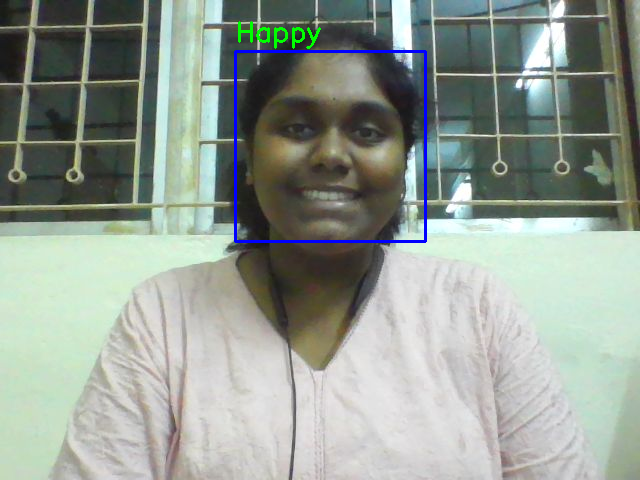

Happy
For emotion 'Happy', suggested movie: Legally Blonde


In [33]:
# Function to suggest a random movie based on emotion
def suggest_movie(emotion):
    if emotion in emotion_movies:
        movies_for_emotion = emotion_movies[emotion]
        if movies_for_emotion:
            return random.choice(movies_for_emotion)
        else:
            return "No movies found for this emotion."
    else:
        return "Invalid emotion."
# Display the frame
cv2_imshow(img)
print(emotion)
# Suggest a movie based on the detected emotion
suggested_movie = suggest_movie(emotion)
print(f"For emotion '{emotion}', suggested movie: {suggested_movie}")
